## Figure 2
### Example network of connections & communities in iambic hexameter

Load packages and data

In [19]:
library(tidyverse)

# networks
library(tidygraph)
library(ggraph) 
library(ggforce) # for geom_mark_hull annotation
library(concaveman)

# colouring
library(wesanderson)
theme_set(theme_minimal())

In [2]:
# load LDA model output
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

# prepare gamma data
gamma <- gamma %>% 
    # select ONLY RNC connections & topics
    filter(corpus == "N") %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

glimpse(gamma)

Rows: 969,525
Columns: 8
$ corpus  <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N…
$ id      <chr> "1-1", "1-2", "1-3", "10-1", "10-2", "100-1", "100-2", "100-3"…
$ year    <chr> "1785", "1785", "1785", "1803", "1803", "1810", "1810", "1810"…
$ author  <chr> "ССБобров", "ССБобров", "ССБобров", "ССБобров", "ССБобров", "А…
$ formula <chr> "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_6", "i…
$ topic   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ gamma   <dbl> 0.019108280, 0.006211180, 0.006451613, 0.006211180, 0.00763358…
$ index   <chr> "N_1-1", "N_1-2", "N_1-3", "N_10-1", "N_10-2", "N_100-1", "N_1…


### Network preparation
#### Extract topic labels

In [4]:
topic_labels <- get_topic_labels(beta, n_labels = 5)
head(topic_labels)

topic,label
<int>,<chr>
1,1_старик девица красный молодой старый
2,2_брат два жена муж другой
3,3_искать исчезать везде дух след
4,4_дева прекрасный краса чистый молодой
5,5_бог давать сила боже господь
6,6_слава великий герой отечество россия


#### Compute edges

In [6]:
edges_raw <- compute_edges(gamma,
                           gamma_thresh = 0.05,
                           time_slice = 5)

# create links
links <- edges_raw %>% 
  mutate(meter = formula) %>%
  # filter out only iambic hexameter
  filter(meter == "iamb_6") %>% 
  # group and count edges
  group_by(slice, meter, corpus) %>% 
  count(slice, meter, edge_id, source, target, sort = T) %>% 
  # filter non-frequent edges
  filter(n > 2) %>% 
  ungroup() 

# quick check
head(links)

slice,meter,corpus,edge_id,source,target,n
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1775,iamb_6,N,39 47,39_ум труд свет наука глупец,47_коль сие зреть любезный смертный,9
1780,iamb_6,N,46 57,46_стих писать читать перо поэт,57_другой хотеть иной становиться говорить,9
1790,iamb_6,N,39 47,39_ум труд свет наука глупец,47_коль сие зреть любезный смертный,9
1775,iamb_6,N,6 47,6_слава великий герой отечество россия,47_коль сие зреть любезный смертный,8
1780,iamb_6,N,39 47,39_ум труд свет наука глупец,47_коль сие зреть любезный смертный,8
1775,iamb_6,N,39 61,39_ум труд свет наука глупец,61_правда суд закон дело зло,7


#### Create edge- and nodelist

In [7]:
edgelist <- links %>% 
  select(source, target, n, meter, slice, corpus) %>% 
  mutate(width = n/10) %>% 
  filter(slice != 1850) %>% 
  rename(N_connections = n) %>% 
  mutate(facet_title = slice)

nodelist <- tibble(source = unique(c(links$target, links$source))) %>% 
  mutate(idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1"))) 

head(edgelist)
head(nodelist) 

source,target,N_connections,meter,slice,corpus,width,facet_title
<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
39_ум труд свет наука глупец,47_коль сие зреть любезный смертный,9,iamb_6,1775,N,0.9,1775
46_стих писать читать перо поэт,57_другой хотеть иной становиться говорить,9,iamb_6,1780,N,0.9,1780
39_ум труд свет наука глупец,47_коль сие зреть любезный смертный,9,iamb_6,1790,N,0.9,1790
6_слава великий герой отечество россия,47_коль сие зреть любезный смертный,8,iamb_6,1775,N,0.8,1775
39_ум труд свет наука глупец,47_коль сие зреть любезный смертный,8,iamb_6,1780,N,0.8,1780
39_ум труд свет наука глупец,61_правда суд закон дело зло,7,iamb_6,1775,N,0.7,1775


source,idn
<chr>,<dbl>
47_коль сие зреть любезный смертный,47
57_другой хотеть иной становиться говорить,57
61_правда суд закон дело зло,61
59_сказать становиться хорошо говорить приходить,59
68_зреть глава глас внимать вещать,68
46_стих писать читать перо поэт,46


In [9]:
summary(edgelist)

    source             target          N_connections      meter          
 Length:382         Length:382         Min.   :3.000   Length:382        
 Class :character   Class :character   1st Qu.:3.000   Class :character  
 Mode  :character   Mode  :character   Median :3.000   Mode  :character  
                                       Mean   :3.652                     
                                       3rd Qu.:4.000                     
                                       Max.   :9.000                     
     slice         corpus              width         facet_title  
 Min.   :1775   Length:382         Min.   :0.3000   Min.   :1775  
 1st Qu.:1780   Class :character   1st Qu.:0.3000   1st Qu.:1780  
 Median :1805   Mode  :character   Median :0.3000   Median :1805  
 Mean   :1803                      Mean   :0.3652   Mean   :1803  
 3rd Qu.:1815                      3rd Qu.:0.4000   3rd Qu.:1815  
 Max.   :1845                      Max.   :0.9000   Max.   :1845  

For the demonstration plot with community detection we select in `custom edgelist` the most frequent edges (those are lying above 3rd qu.) and test different time slices for better visuals.

In [10]:
custom_edgelist <- function(edgelist_input, meter_v, slices, min_connections) {
    edgelist_input %>% 
    #filter time slice 
    filter(slice %in% slices) %>% 
    # select meter and connection frequency threshold
    filter(meter == meter_v & N_connections > min_connections) %>% 
    select(-slice) %>% 
    mutate(source_target = paste0(source, "__", target)) %>% 
    group_by(source_target) %>% 
    # sum number of connections for the whole period (if more than 1 time slice is chosen)
    summarise(sum_links = sum(N_connections)) %>% 
    separate(source_target, into = c("source", "target"), sep = "__")
}

custom_nodelist <- function(source_vec, target_vec) {
    x <- tibble(source = unique(c(source_vec,
                                 target_vec)),
               idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1")))
    return(x)
}

In [11]:
edgelist_i6 <- custom_edgelist(edgelist, 
                               meter_v = "iamb_6", 
                            # choices for the Fig. 2:
                               slices = c(1775:1849), 
                               min_connections = 4)
head(edgelist_i6)
nrow(edgelist_i6)
nodelist_i6 <- custom_nodelist(edgelist_i6$source, edgelist_i6$target)
head(nodelist_i6)

source,target,sum_links
<chr>,<chr>,<int>
12_любовь сердце страсть кровь чувство,54_жизнь радость надежда день мечта,5
13_меч бой враг герой поле,68_зреть глава глас внимать вещать,13
16_древний век храм москва глава,39_ум труд свет наука глупец,6
19_муза певец слава дар поэт,46_стих писать читать перо поэт,16
19_муза певец слава дар поэт,47_коль сие зреть любезный смертный,6
20_богатый жить дом служить бедный,47_коль сие зреть любезный смертный,5


[1] 41

source,idn
<chr>,<dbl>
12_любовь сердце страсть кровь чувство,12
13_меч бой враг герой поле,13
16_древний век храм москва глава,16
19_муза певец слава дар поэт,19
20_богатый жить дом служить бедный,20
21_цветок роза цвет цвести венок,21


### Create network

In [12]:
# create tidy graph
net_t <- tbl_graph(nodes = nodelist_i6,
                  edges = edgelist_i6,
                  directed = FALSE)

# detect communities with louvain method
t_community <- net_t %>% 
    activate(nodes) %>% 
    mutate(community = as.factor(group_louvain())) 

Manual reviewing and interpretation of communities

In [13]:
t_community %>% 
    activate(nodes) %>% 
    filter(community == 1)

t_community %>% 
    activate(nodes) %>% 
    filter(community == 2)

t_community %>% 
    activate(nodes) %>% 
    filter(community == 3)

t_community %>% 
    activate(nodes) %>% 
    filter(community == 4)

t_community %>% 
    activate(nodes) %>% 
    filter(community == 5)

# A tbl_graph: 10 nodes and 13 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 10 × 3 (active)
  source                                  idn community
  <chr>                                 <dbl> <fct>    
1 19_муза певец слава дар поэт             19 1        
2 20_богатый жить дом служить бедный       20 1        
3 29_слово сказать говорить знать никто    29 1        
4 31_враг смерть страшный ужасный кровь    31 1        
5 41_лев волк зверь собака большой         41 1        
6 46_стих писать читать перо поэт          46 1        
# … with 4 more rows
#
# Edge Data: 13 × 3
   from    to sum_links
  <int> <int>     <int>
1     1     6        16
2     2     8         6
3     3     7         6
# … with 10 more rows

# A tbl_graph: 6 nodes and 7 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 6 × 3 (active)
  source                                   idn community
  <chr>                                  <dbl> <fct>    
1 13_меч бой враг герой поле                13 2        
2 16_древний век храм москва глава          16 2        
3 39_ум труд свет наука глупец              39 2        
4 49_гроб могила прах земля мертвый         49 2        
5 6_слава великий герой отечество россия     6 2        
6 68_зреть глава глас внимать вещать        68 2        
#
# Edge Data: 7 × 3
   from    to sum_links
  <int> <int>     <int>
1     1     6        13
2     2     3         6
3     4     6         5
# … with 4 more rows

# A tbl_graph: 6 nodes and 5 edges
#
# An unrooted tree
#
# Node Data: 6 × 3 (active)
  source                                    idn community
  <chr>                                   <dbl> <fct>    
1 21_цветок роза цвет цвести венок           21 3        
2 23_белый грудь черный лицо кудри           23 3        
3 24_вода луг тень ручей роща                24 3        
4 52_грудь уста сладкий нега слеза           52 3        
5 48_тишина мирный тихий счастливый покой    48 3        
6 50_петь песня звук песнь певец             50 3        
#
# Edge Data: 5 × 3
   from    to sum_links
  <int> <int>     <int>
1     1     2         5
2     1     3         6
3     2     4         6
# … with 2 more rows

# A tbl_graph: 4 nodes and 3 edges
#
# An unrooted tree
#
# Node Data: 4 × 3 (active)
  source                                idn community
  <chr>                               <dbl> <fct>    
1 40_год время новый проходить день      40 4        
2 47_коль сие зреть любезный смертный    47 4        
3 7_человек свет век жить мир             7 4        
4 71_мир дух сила свет творец            71 4        
#
# Edge Data: 3 × 3
   from    to sum_links
  <int> <int>     <int>
1     1     2         5
2     2     4         6
3     2     3         6

# A tbl_graph: 2 nodes and 1 edges
#
# An unrooted tree
#
# Node Data: 2 × 3 (active)
  source                                   idn community
  <chr>                                  <dbl> <fct>    
1 12_любовь сердце страсть кровь чувство    12 5        
2 54_жизнь радость надежда день мечта       54 5        
#
# Edge Data: 1 × 3
   from    to sum_links
  <int> <int>     <int>
1     1     2         5

In [14]:
nodelist[nodelist$idn %in% c(46, 20, 41, 6, 13, 16, 24, 48, 40, 71, 7, 12, 54, 21, 71),]

source,idn
<chr>,<dbl>
46_стих писать читать перо поэт,46
71_мир дух сила свет творец,71
48_тишина мирный тихий счастливый покой,48
24_вода луг тень ручей роща,24
13_меч бой враг герой поле,13
16_древний век храм москва глава,16
54_жизнь радость надежда день мечта,54
6_слава великий герой отечество россия,6
41_лев волк зверь собака большой,41


In [15]:
# create and translate labels

labels <- tibble(community = c(1,2,3,4,5),
                label = c("Didactic", 
                          "Patriotic", 
                          "Idyll", 
                          "Philosophic", 
                          "Love elegy"),
                desc = c("46 verse-to write-to read-plume-poet\n41 lion-wolf-animal-dog-big\n20 rich-live-house-serve-poor",
                        "6 glory-great-hero-fatherland-russia\n13 sword-fight-enemy-hero-field\n16 ancient-century-temple-moscow-head", 
                         "24 water-meadow-shade-spring-grove\n48 quietness-peaceful-quiet-happy-rest\n21 flower-rose-bloom-blossom-wreath", 
                         "7 human-light-century-live-world\n40 year-time-new-to pass-day\n71 world-spirit-power-light-creator", 
                         "12 love-heart-passion-blood-feeling\n54 life-joy-hope-day-dream")) %>% 
    mutate(community = as.factor(community))

# attach labels to nodes df
t_labeled <- t_community %>% 
    activate(nodes) %>% 
    left_join(labels, by = "community")

In [16]:
# select colour palette

plt <- c(wes_palette("Darjeeling1")[2],
        wes_palette("Darjeeling1")[5],
        wes_palette("Darjeeling1")[4],
        wes_palette("Darjeeling1")[3],
        wes_palette("Darjeeling1")[1])

## Fig. 2

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


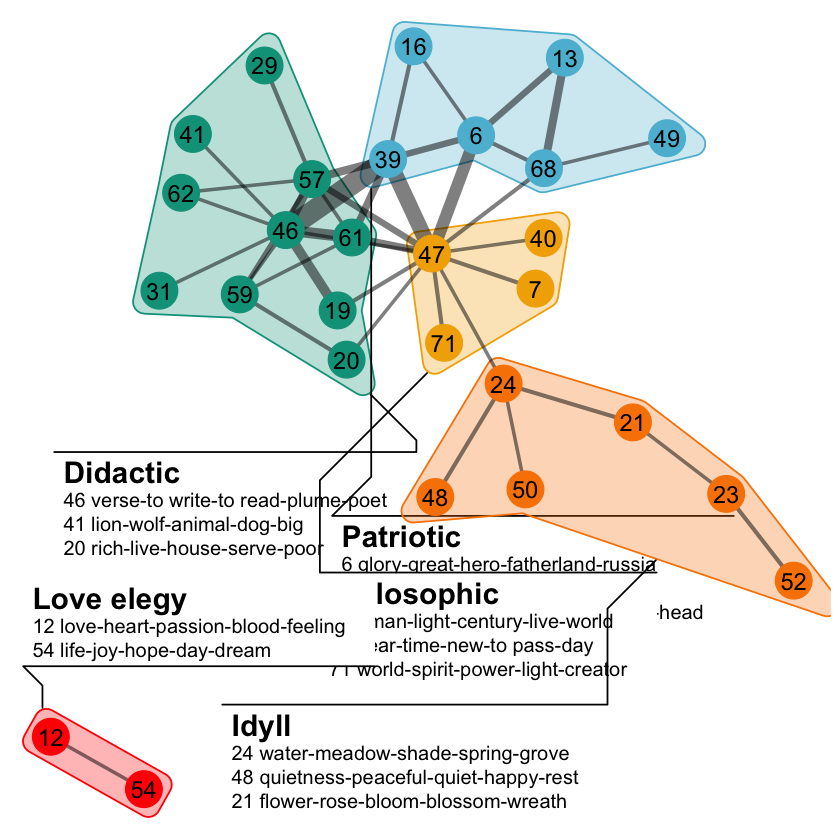

In [17]:
## issue: automatic geom_hull calculation works uglier than attaching separate hulls

p6 <- t_labeled %>% 
    ggraph('kk') + 
    
    # create hulls
    # didactic poetry hull
    # community label and description are attached to each hull
    geom_mark_hull(aes(x,y, fill = community,
                       color = community,
                      label = label, description = desc,
                      filter = community == 1),
                   label.buffer = unit(10, 'mm'),
                   label.minwidth = 100,
                   label.fontsize = c(18, 12),
                   con.cap = 1
                  ) + 

    # patriotic
    geom_mark_hull(aes(x,y, fill = community,
                       color = community,
                      label = label, description = desc,
                      filter = community == 2),
                   label.buffer = unit(1, 'mm'),
                   label.minwidth = 100,
                   label.fontsize = c(18, 12),
                   con.cap = 1
                  ) + 

    # philosophic
    geom_mark_hull(aes(x,y, fill = community,
                       color = community,
                      label = label, description = desc,
                      filter = community == 4),
                   label.buffer = unit(40, 'mm'),
                   label.minwidth = 100,
                   label.fontsize = c(18, 12),
                   con.cap = 1
                  ) + 

    # idyll
    geom_mark_hull(aes(x,y, fill = community,
                       color = community,
                      label = label, description = desc,
                      filter = community == 3),
                   label.buffer = unit(30, 'mm'),
                   label.minwidth = 100,
                   label.fontsize = c(18, 12),
                   con.cap = 1
                  ) + 

    # love elegy
    geom_mark_hull(aes(x,y, fill = community,
                       color = community,
                      label = label, description = desc,
                      filter = community == 5),
                   label.buffer = unit(7, 'mm'),
                   label.minwidth = 100,
                   label.fontsize = c(18,12),
                   con.cap = 1
                  ) + 

    # edges
    geom_edge_link(aes(width = sum_links), 
                   alpha = 0.5) + 
    
    # nodes
    geom_node_point(aes(colour = community
                       ), size = 10) + 
    # topic id-s inside nodes
    geom_node_text(aes(label = idn), size = 5) + 

    # colouring
    scale_color_manual(values = plt) + 
    scale_fill_manual(values = plt) + 

    # labs if needed
    #labs(title = "Topic communities in iambic hexameter",
    #    subtitle = "Corpus: 1495 poems in iambic hexameter in Russian, dated 1775-1849\nLDA topic model (k=75)\nNodes are topics, edges built if two topics are highly probable in the same text") + 
    
    # text sizes
    theme(legend.position = "None",
         plot.title = element_text(size = 20, face = "bold"),
         plot.subtitle = element_text(size = 16)) 
p6

In [18]:
ggsave(file = "../plots/Fig_2.png", plot = p6, 
      bg = "white", width = 12, height = 8, dpi = 300)